<p align="center">
<img style="width:60%" src="http://www.clipartbest.com/cliparts/yio/LdA/yioLdA9eT.jpg">
</p>

[Image source](http://www.clipartbest.com/clipart-yioLdA9eT)

<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">House prices.<br> Part 4. <br> Ensemble prediction.</h1>

## Please use nbviewer to read this notebook to use all it's features:

https://nbviewer.org/github/sersonSerson/Projects/blob/master/Regression/HousePrice/01%20EDA.ipynb

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>

## 1. [Load predictions.](#Step1)
## 2. [Analyze predictions.](#Step2)
## 3. [Generate submission.](#Step3)
## 4. [Conclusion.](#Step4)

In [73]:
# Imports.
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

In [74]:
# Configure Matplotlib
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (16,5)
plt.rcParams['figure.facecolor'] = '#daf2e1'
plt.rcParams['axes.facecolor'] = '#daf2e1'
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['figure.titlesize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['image.cmap']=cm.tab10
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
cmap = cm.tab10
blue = cmap.colors[0]
orange = cmap.colors[1]
green = cmap.colors[2]
colors = [blue, orange, green]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
matplotlib.cm.register_cmap("newcolormap", cmap)
cpal = sns.color_palette("newcolormap", n_colors=60)
sns.set_palette('muted')

In [75]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
warnings.filterwarnings('ignore')

<div id="Step1">
</div>

# <span style="color:#01872A; display: block; padding:10px;background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 1. Load predictions.</span>

In [76]:
def load_data(model_names):
    columns = dict()
    for model_name in model_names:
        path = f'Predictions/{model_name}.csv'
        if os.path.exists(path):
            df = pd.read_csv(path, delimiter=',', index_col='Id')
            columns[model_name] = df['SalePrice']
    predictions = pd.DataFrame(columns)
    return predictions

## Predictions for the test set.

In [77]:
model_names = ['RidgeRegression', 'ScaledANN']
test_predictions = load_data(model_names)
test_predictions.head()

,RidgeRegression,ScaledANN
Id,,
1461,108655.953459,120436.41
1462,166438.744594,164586.88
1463,183138.769308,192675.23
1464,205352.534098,202901.52
1465,197382.798742,173106.67


## Preditions and actual values for validation set.

In [78]:
val_model_names = ['RidgeRegressionVal', 'ScaledANNVal']
val_predictions = load_data(val_model_names)
val_predictions.head()

,RidgeRegressionVal,ScaledANNVal
Id,,
16,128337.139560,128710.266
24,131493.425799,118725.270
30,63914.410001,70568.695
31,82844.133748,92412.195
33,202768.058761,185881.000


In [79]:
y_val = load_data(['y_val'])['y_val']

<div id="Step2">
</div>

# <span style="color:#01872A; display: block; padding:10px;background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 2. Analyze predictions.</span>

## Check correlation between validation predictions and actual values.
* Predictions are correlated with each other.
* Ridge regression correlation with actual values is higher than ANN
prediction correlation.

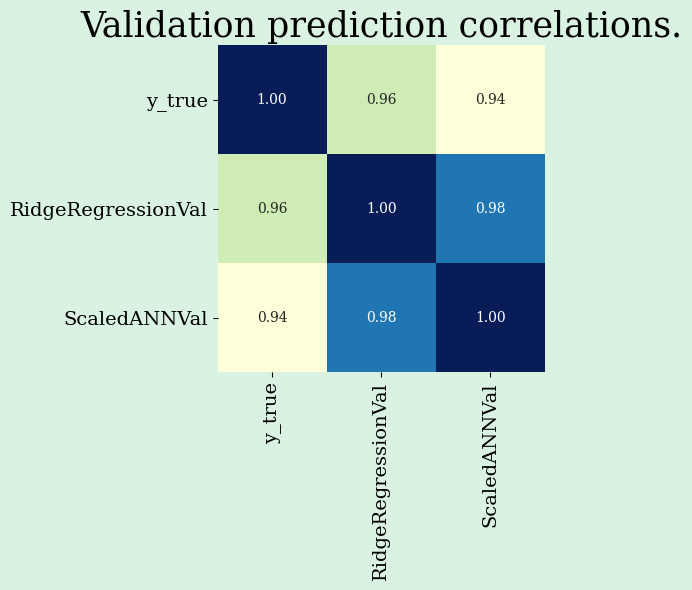

In [80]:
def pred_correlation(df, y_true=None):
    df['y_true'] = y_true
    corr = df.corr()
    if y_true is not None:
        sorted_index = \
            corr['y_true'].apply(np.abs).sort_values(ascending=False).index
        sorted_corr = corr[sorted_index].reindex(sorted_index)
        sorted_corr.head()
    else:
        sorted_corr = corr
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(sorted_corr, ax=ax, annot=True, fmt='.2f',
            cmap='YlGnBu', cbar=False, square=True)
    ax.set_title('Validation prediction correlations.')
    plt.tight_layout()
    plt.show()
pred_correlation(val_predictions.copy(), y_val)

# Check individual model scores
* Ridge regression error is lower than ANN prediction error.

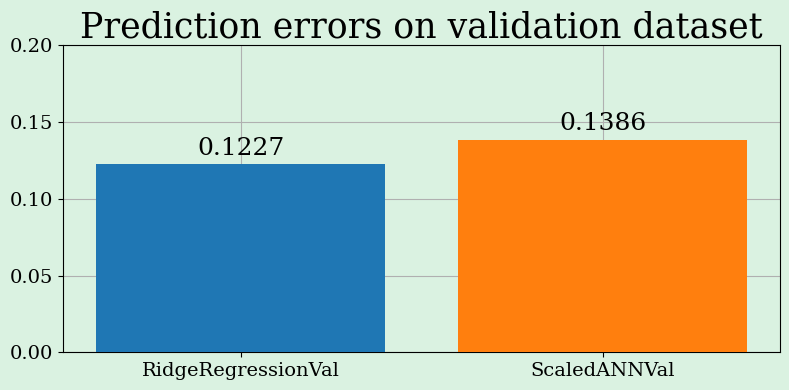

In [81]:
def rmsle(y, y_pred):
    if len(y) != len(y_pred):
        return 0
    sum = 0
    for real, pred in zip(y, y_pred):
        if real < 0:
            real = 0,
        if pred < 0:
            pred = 0
        p = np.log(real + 1)
        r = np.log(pred + 1)
        sum += np.square(p - r)
    result = np.sqrt(sum / len(y_pred))
    if isinstance(result, np.ndarray):
        result = result[0]
    return result

def autolabel(rects, ax, decimals=2):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for index, rect in enumerate(rects):
        height = rect.get_height()
        value = round(height, decimals)
        ax.annotate('{}'.format(value),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    size=18,# 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def plot_scores(scores_df):
    fig, ax = plt.subplots(figsize=(8, 4))
    rects = ax.bar(scores_df['Scores'].index, scores_df['Scores'].values,
                   zorder=3, color=cm.tab10.colors)
    autolabel(rects, ax, decimals=4)
    ax.set_title('Prediction errors on validation dataset')
    ax.set_ylim(0, 0.20)
    plt.tight_layout()
    plt.show()

scores = dict()
for column in val_predictions.columns:
    scores[column] = rmsle(y_val, val_predictions[column])

scores_df = pd.DataFrame({'Scores': scores.values()}, index=scores.keys())
scores_df.sort_values('Scores', inplace=True, ascending=True)
plot_scores(scores_df)

# Visually compare model predictions:
* Both models are not good for expensive houses.
* Both models predict cheap house prices quite well.

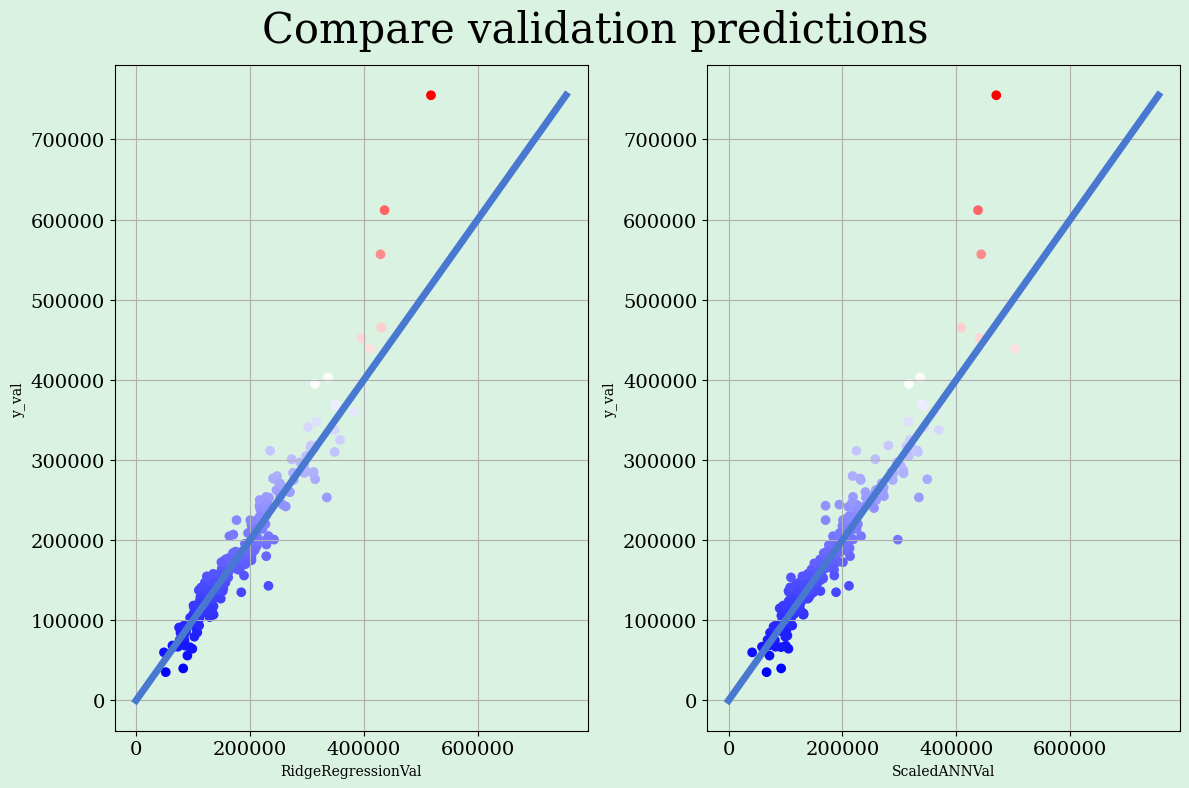

In [113]:
def compare_preds_to_truth(val_predictions, y_true):
    n_columns = len(val_predictions.columns)
    max_value = max(val_predictions.max().max(), y_val.max())
    fig, axes = plt.subplots(1, n_columns, figsize=(12, 8))
    for ax, column in zip(axes.ravel(), val_predictions.columns):
        ax.set_xlabel(column)
        ax.set_ylabel(y_true.name)
        ax.scatter(val_predictions[column], y_true, c=y_true, cmap='bwr')
        ax.plot((0, max_value), (0, max_value))
    fig.suptitle('Compare validation predictions')
    plt.tight_layout()
    plt.show()

compare_preds_to_truth(val_predictions, y_val)

<div id="Step3">
</div>

# <span style="color:#01872A; display: block; padding:10px;background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 3. Generate submission.</span>

## For final submission use more of RidgeRegression prediction as it has higher score.

In [82]:
test_predictions['Submission'] = test_predictions['ScaledANN'] * 0.3 \
                                 + test_predictions['RidgeRegression'] * 0.7
test_predictions['Submission'].head()

Id
1461    112190.090421
1462    165883.185216
1463    185999.707516
1464    204617.229868
1465    190099.960120
Name: Submission, dtype: float64

## Generate ensemble submission.

In [83]:
def generate_submission(preds):
    submission_df = pd.DataFrame({'Id': preds.index,
                                'SalePrice': preds})
    path = 'Predictions/EnsembleSubmission.csv'
    submission_df.to_csv(path, index=False)
    print(f'Submission saved to {path}!')
generate_submission(test_predictions['Submission'].astype(int))

Submission saved to Predictions/EnsembleSubmission.csv!


<div id="Step4">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 4. Conclusion.</span>

1. Simple Ridge Regression model was able to make very good prediction.
2. Score of 0.11732 allowed to finish in top 3% of the contenders.
3. Extensive feature generation was required.
4. Ensemble of models was used to improve results a bit.
